## call "~/.local/bin/poetry" if poetry keyword not working on mac

In [32]:
import datetime
import geopandas
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [33]:
# TODO try only with best performing numeric columns for input into model first
# TODO select features for deep learning model after ranking features with random forest (feature importance)
# TODO lstm network
# DONE TODO SMOTE algorithm, for upsampling havested fields; we only have ~300 :(
    
    
# TODO convert sample_idx into cyclic numeric values using sin or cos.
    # https://datascience.stackexchange.com/questions/17759/encoding-features-like-month-and-hour-as-categorial-or-numeric
    


In [34]:
# 1- upsample with smote DONE
# 2- select best featues with random forests

In [35]:
#local scripts

from scripts import veg_indices, utilities, plots
#from scripts.utilities import *

In [36]:
# cpied from learning_about-data.ipynb
BANDS_DICT = {   'B2': 'Blue',
            'B3': 'Green',
            'B4': 'Red',
            'B5': 'Red_Edge_1',
            'B6': 'Red_Edge_2',
            'B7': 'Red_Edge_3',
            'B8': 'NIR',
            'B8A': 'Red_Edge_4',
            'B11': 'SWIR_1',
            'B12': 'SWIR_2'}

BANDS = list(BANDS_DICT.keys())

In [37]:
# cpied from learning_about-data.ipynb
DF = geopandas.read_file('../data/merged_images.geojson')
DF.rename(columns = {'is_within_period':'har_evnt'}, inplace = True)
NUM_SAMPLES = len(np.unique(DF.image_idx)) - 1

In [38]:
DF

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,NDVI,finHarvDat,lat,lon,point_idx,start_date,end_date,har_evnt,image_idx,geometry
0,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,2022-08-11,50.655048,25.458684,p0,2022-01-08,2022-01-28,False,i0,POINT (25.45868 50.65505)
1,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.294633,36.289471,p1,2022-01-08,2022-01-28,False,i0,POINT (36.28947 50.29463)
2,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.860849,32.548484,p2,2022-01-08,2022-01-28,False,i0,POINT (32.54848 50.86085)
3,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.928689,31.637558,p3,2022-01-08,2022-01-28,False,i0,POINT (31.63756 50.92869)
4,0.1424,0.1083,0.030,0.0432,0.0631,0.07150,0.07760,0.08510,0.1066,0.1043,0.256335,2022-07-23,48.307964,37.348245,p4,2022-01-08,2022-01-28,False,i0,POINT (37.34824 48.30796)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9481,0.2557,0.1875,0.065,0.0740,0.0973,0.11695,0.14255,0.15525,0.1920,0.1847,0.327342,NaT,49.723156,36.817274,p553,2022-12-10,2022-12-30,False,i16,POINT (36.81727 49.72316)
9482,0.1616,0.1235,0.028,0.0442,0.0525,0.06390,0.08950,0.09310,0.1152,0.1073,0.373882,NaT,45.578351,28.700480,p554,2022-12-10,2022-12-30,False,i16,POINT (28.70048 45.57835)
9483,0.1675,0.1030,0.043,0.0678,0.0460,0.10960,0.23980,0.26430,0.2832,0.2783,0.720535,NaT,46.693510,35.051003,p555,2022-12-10,2022-12-30,False,i16,POINT (35.05100 46.69351)
9484,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,2022-07-30,50.451929,33.668204,p556,2022-12-10,2022-12-30,False,i16,POINT (33.66820 50.45193)


In [39]:
# cpied from learning_about-data.ipynb
df = DF.copy()
df = df[(df.NDVI) != 0] # drop invalid points
VEG_INDICES_NAMES = veg_indices.add_veg_indices(df) + ['NDVI'] 
df, VEG_DIFF_NAMES = veg_indices.get_added_veg_diff(df, VEG_INDICES_NAMES)
NUMERIC_COLS = BANDS + VEG_INDICES_NAMES + VEG_DIFF_NAMES


""" 
# only look at samples 6, 7, 8, 9
new_df = None
for i in range(6, 9 + 1):

    curr_df = df[df["image_idx"] == f"s{i}"]
    if(type(new_df) == type(None)):
        new_df = curr_df
    else:
        new_df = pd.concat([new_df, curr_df])
df = new_df
"""

print(df.columns, df.shape)


# For each 3-week image, standarize each column
df = utilities.get_rm_outlier_standarize(df, NUMERIC_COLS, rm_outliers=False)

all_df_cols = list(df.columns)


Added:  ['RVI', 'ARVI', 'PSSRa', 'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI', 'NDVIre', 'NIRv', 'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI', 'NDWI', 'NDSI']
(189, 21) (189, 42)
       B11      B12       B2       B3       B4      B5       B6       B7   
0  0.16620  0.13040  0.03920  0.05140  0.07190  0.0738  0.08200  0.08860  \
1  0.13330  0.12505  0.86005  0.84640  0.85600  0.8646  0.83640  0.81055   
2  0.21220  0.17845  0.04550  0.05340  0.06855  0.0890  0.11565  0.12485   
3  0.23270  0.21225  0.84400  0.83195  0.82840  0.8403  0.81605  0.79195   
4  0.21385  0.15000  0.05220  0.08115  0.09410  0.1311  0.18360  0.19200   

        B8      B8A  ...  EVI_diff NDTI_diff  NDMI_diff  MSI_diff  GCI_diff   
0  0.10920  0.09940  ... -0.011492 -0.015318  -0.063197  0.186143 -0.343079  \
1  0.84120  0.77320  ...  0.028819  0.090757  -0.166715  0.102017  0.008493   
2  0.14060  0.13700  ...  0.099190  0.095000  -0.102871  0.286835  0.689064   
3  0.82835  0.75025  ... -0.077670 -0

In [44]:
%%script echo skipping

compression_opts = dict(method='zip',
                        archive_name='out.csv')
df.to_csv("dataframe.zip", index=True, compression=compression_opts)

#### metric0: Bhattacharyya Distance
- s6
    * RVI
    * NDVI
- s7
    * B12
    * B4
    * NDMI_diff
- s8
    * NDSI_diff
    * NDI45
- s9 
    * NDSI_diff
    * NBRI
    * BSI_diff
- ["RVI", "NDVI", "B12", "B4", "NDMI_diff", "NDSI_diff", "NDI45", "NDSI_diff", "NBRI", "BSI_diff"]



#### metric1: Hellinger Distance (same results as metric0!)
- s6
    * RVI
    * NDVI
- s7
    * B12
    * B4
    * NDMI_diff
- s8
    * NDSI_diff
    * NDI45
- s9 
    * NDSI_diff
    * NBRI
    * BSI_diff

    
#### metric2: Two-sample Kolmogorov Smirnov test P-Value
- s6
    * RVI
    * BSI_diff
- s7
    * NDVI
    * IRECI_diff
- s8
    * BSI_diff
    * NBRI
    * NBRI_diff
    * NDMI
    * ARVI
    * MSI_diff
- s9 
    * BSI_diff
    * IRECI_diff
- ["RVI", "BSI_diff", "NDVI", "IRECI_diff", "BSI_diff", "NBRI", "NBRI_diff", "NDMI", "ARVI", "MSI_diff"]


#### metric3: Jensen-Shannon Divergence (JSD) 
- s6
    * B6
    * NDVIre_diff
    * B2
- s7
    * ARVI_diff
    * B6
    * B7
    * B8A
- s8
    * B12
- s9 
    * MTCI
    * NDVIre_diff

- ["B6", "NDVIre_diff", "B2", "ARVI_diff", "B6", "B7", "B8A", "B12", "MTCI", "NDVIre_diff"]

In [10]:
def get_manually_selected():
    METRIC0 = ["RVI", "NDVI", "B12", "B4", "NDMI_diff", "NDSI_diff", "NDI45", "NDSI_diff", "NBRI", "BSI_diff"]
    METRIC1 = METRIC0
    METRIC2 = ["RVI", "BSI_diff", "NDVI", "IRECI_diff", "BSI_diff", "NBRI", "NBRI_diff", "NDMI", "ARVI", "MSI_diff"]
    METRIC3 = ["B6", "NDVIre_diff", "B2", "ARVI_diff", "B6", "B7", "B8A", "B12", "MTCI", "NDVIre_diff"]

    return np.unique(np.concatenate([METRIC0, METRIC1, METRIC2, METRIC3]))

def get_ordered_rdm_forests_features():
    # first one is the most important
    return ['MTCI', 'NDVIre_diff', 'NDVI_diff', 'MTCI_diff', 'PSSRa', 'NDI45_diff',
       'EVI_diff', 'RVI', 'ARVI_diff', 'CIr', 'CIr_diff', 'NDTI_diff', 'NDVI',
       'NDI45', 'B11', 'NIRv_diff', 'NBRI_diff', 'PSSRa_diff', 'B4', 'B12',
       'MCARI', 'B5', 'B6', 'EVI', 'GCI_diff', 'MCARI_diff', 'GNDVI_diff',
       'NIRv', 'B3', 'NDMI_diff', 'B8', 'B7', 'IRECI_diff', 'NDTI', 'B8A',
       'NBRI', 'B2', 'NDSI', 'ARVI', 'NDVIre', 'GNDVI', 'IRECI', 'BSI_diff',
       'NDWI_diff', 'NDSI_diff', 'MSI_diff', 'GCI', 'BSI', 'MSI', 'NDMI',
       'NDWI']
    

#SELECTED_FEATURES = get_manually_selected()

SELECTED_FEATURES = NUMERIC_COLS
SELECTED_FEATURES = df[SELECTED_FEATURES].dropna(axis=1).columns


#SELECTED_FEATURES = get_ordered_rdm_forests_features()[:21 + 1] # get top 21 features

#SELECTED_FEATURES = ["NDVI", "NDVI_diff", "B2", "B3", "B4"]

print(SELECTED_FEATURES)

def get_X_y(dataframe: pd.DataFrame):
    df_X = dataframe[SELECTED_FEATURES]
    df_X = df_X.dropna(axis=1)
    X = df_X.to_numpy().reshape((df_X.shape[0], df_X.shape[1], 1))
    y = dataframe["har_evnt"].to_numpy().astype(np.float32)
    return X, y

Index(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'RVI',
       'ARVI', 'PSSRa', 'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI',
       'NDVIre', 'NIRv', 'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI',
       'NDWI', 'NDSI', 'NDVI', 'RVI_diff', 'ARVI_diff', 'PSSRa_diff',
       'NDI45_diff', 'GNDVI_diff', 'MCARI_diff', 'IRECI_diff', 'CIr_diff',
       'MTCI_diff', 'NDVIre_diff', 'NIRv_diff', 'EVI_diff', 'NDTI_diff',
       'NDMI_diff', 'MSI_diff', 'GCI_diff', 'NBRI_diff', 'BSI_diff',
       'NDWI_diff', 'NDSI_diff', 'NDVI_diff'],
      dtype='object')


# Random Upsampling (not used)

In [11]:
%%script echo skipping

har_evnt_true_df = df[df["har_evnt"]]
har_evnt_false_df = df[df["har_evnt"] == False]
print(har_evnt_true_df.shape)
print(har_evnt_false_df.shape)

from sklearn.utils import resample

upsampled_har_evnt_true_df = resample(har_evnt_true_df, n_samples=har_evnt_false_df.shape[0],
                                                 replace=True, random_state=42)
print(upsampled_har_evnt_true_df.shape)

df = pd.concat([upsampled_har_evnt_true_df, har_evnt_false_df])
df.shape

skipping


# Separate Train, Val datasets (based on points)

In [12]:
%%script echo skipping
from sklearn.model_selection import train_test_split

            
points_df_list = []
for p in  df['point_idx'].unique(): # ['p0','p1','p2','p3','p4', ...]
    curr_df = df[df["point_idx"] == p]
    points_df_list.append(curr_df)
len(points_df_list)

training_df_list, validation_df_list = train_test_split(points_df_list, train_size=0.8, random_state=42)

print(len(training_df_list))
print(len(validation_df_list))


# combine into two dataframes
train_df = pd.concat(training_df_list)
validate_df = pd.concat(validation_df_list)
train_df.shape, validate_df.shape

skipping


# Separate Train, Val datasets

In [13]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df.har_evnt)

print(train_df.shape, validate_df.shape)
print(np.unique(train_df.har_evnt, return_counts=True))
print(np.unique(validate_df.har_evnt, return_counts=True))

(4216, 63) (1054, 63)
(array([False,  True]), array([3966,  250]))
(array([False,  True]), array([991,  63]))


# Convert to Numpy & SMOTE Upsampling

In [14]:
X_train, y_train = get_X_y(train_df)
print(X_train.shape, y_train.shape)
X_validate, y_validate = get_X_y(validate_df)
print(X_validate.shape, y_validate.shape)


(4216, 52, 1) (4216,)
(1054, 52, 1) (1054,)


In [15]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

def upsample(X, y):
    print(X.shape)
    # oversampling the train dataset using SMOTE
    smt = SMOTE()
    counter = Counter(y)
    print('Before',counter)
    X = X.reshape(X.shape[0], X.shape[1]) # remove last dim in (6678, 21, 1)
    X, y = smt.fit_resample(X, y)
    X_sm, y_sm = smt.fit_resample(X, y)

    counter = Counter(y_sm)
    print('After',counter)

    X = X.reshape(X.shape[0], X.shape[1], 1)
    print("")
    return X, y

X_train, y_train = upsample(X_train, y_train)


(4216, 52, 1)
Before Counter({0.0: 3966, 1.0: 250})
After Counter({0.0: 3966, 1.0: 3966})



In [16]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
model = tf.keras.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 batch_normalization (BatchN  (None, 800)              3200      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                25632     
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])


In [19]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_validate, y_validate))


Epoch 1/20


2023-05-13 17:43:30.388608: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


248/248 [==============================] - 1s 2ms/step - loss: 0.3892 - binary_accuracy: 0.8225 - val_loss: 0.3470 - val_binary_accuracy: 0.9004
Epoch 2/20
248/248 [==============================] - 0s 2ms/step - loss: 0.2496 - binary_accuracy: 0.9056 - val_loss: 0.3542 - val_binary_accuracy: 0.8805
Epoch 3/20
248/248 [==============================] - 0s 2ms/step - loss: 0.2083 - binary_accuracy: 0.9204 - val_loss: 0.4566 - val_binary_accuracy: 0.8558
Epoch 4/20
248/248 [==============================] - 0s 2ms/step - loss: 0.1728 - binary_accuracy: 0.9349 - val_loss: 0.4245 - val_binary_accuracy: 0.8918
Epoch 5/20
248/248 [==============================] - 0s 1ms/step - loss: 0.1607 - binary_accuracy: 0.9407 - val_loss: 0.4584 - val_binary_accuracy: 0.9061
Epoch 6/20
248/248 [==============================] - 0s 1ms/step - loss: 0.1379 - binary_accuracy: 0.9515 - val_loss: 0.4756 - val_binary_accuracy: 0.9070
Epoch 7/20
248/248 [==============================] - 0s 2ms/step - loss: 0

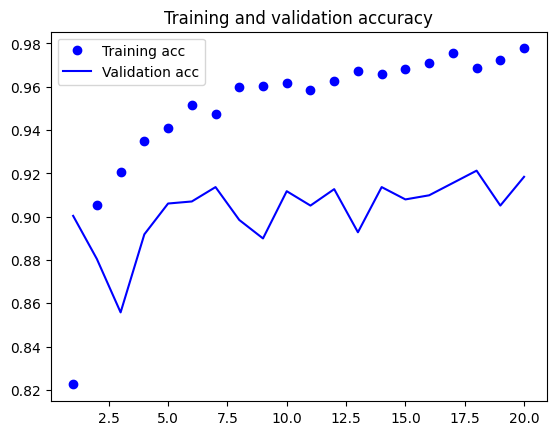

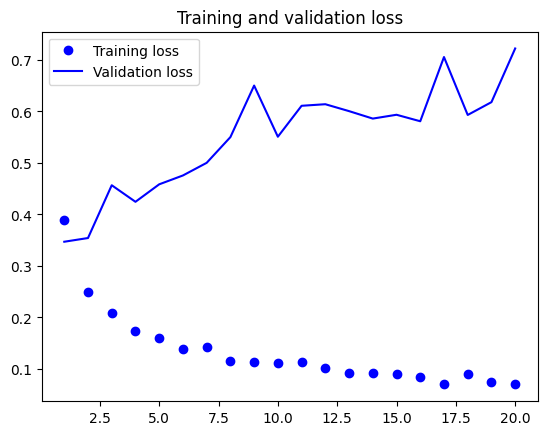

In [20]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
import sklearn
func = np.vectorize(lambda x: 0 if x < 0.5 else 1)

In [22]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

def plot_confusion_matrix(actual, predicted):
    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()

X_train
248/248 [==============================] - 0s 509us/step
(array([0, 1]), array([3909, 4023]))
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3966
         1.0       0.98      0.99      0.99      3966

    accuracy                           0.99      7932
   macro avg       0.99      0.99      0.99      7932
weighted avg       0.99      0.99      0.99      7932



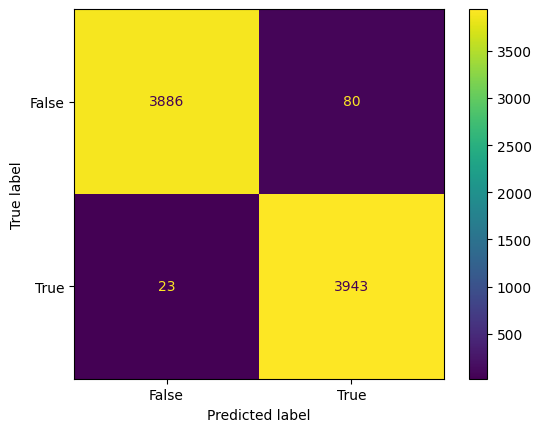

In [23]:
print("X_train")
y_predict = np.array(list(model.predict(X_train)))
y_predict = y_predict.reshape(y_predict.shape[0])
print(np.unique(func(y_predict), return_counts=True))
print(sklearn.metrics.classification_report(y_train, func(y_predict)))
plot_confusion_matrix(y_train, func(y_predict))

X_validate
33/33 [==============================] - 0s 494us/step
(array([0, 1]), array([967,  87]))
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96       991
         1.0       0.37      0.51      0.43        63

    accuracy                           0.92      1054
   macro avg       0.67      0.73      0.69      1054
weighted avg       0.93      0.92      0.92      1054



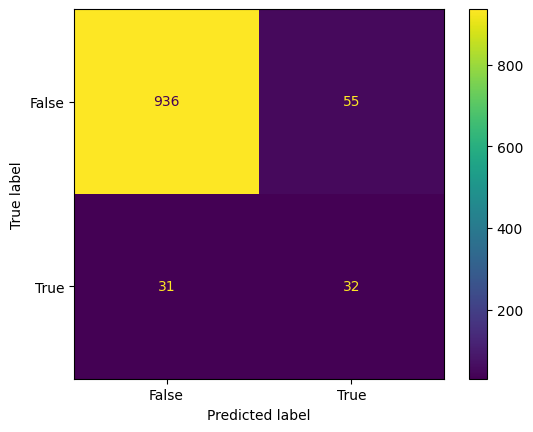

In [24]:
print("X_validate")

y_predict = np.array(list(model.predict(X_validate)))
y_predict = y_predict.reshape(y_predict.shape[0])
print(np.unique(func(y_predict), return_counts=True))
print(sklearn.metrics.classification_report(y_validate, func(y_predict)))
plot_confusion_matrix(y_validate, func(y_predict))

In [ ]:

plot_confusion_matrix(y_train, y_predict)

In [25]:
def rm_extradim(X, y):
    X, y = X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0])
    return X, y

# Random Forests Feature Selection

In [26]:

X_train, y_train = rm_extradim(X_train, y_train)
X_validate, y_validate = rm_extradim(X_validate, y_validate)

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_predict = rf.predict(X_validate)


accuracy_score(y_validate, y_predict)

0.9212523719165086

In [27]:
print(sklearn.metrics.classification_report(y_validate, y_predict))



              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       991
         1.0       0.34      0.35      0.35        63

    accuracy                           0.92      1054
   macro avg       0.65      0.65      0.65      1054
weighted avg       0.92      0.92      0.92      1054



In [28]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([3966, 3966]))

In [29]:
feature_importances_df = pd.DataFrame(rf.feature_importances_,
                    index=SELECTED_FEATURES, 
                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_df

,importance
MTCI,0.056904
PSSRa,0.050744
PSSRa_diff,0.038903
IRECI_diff,0.037736
RVI,0.037349
CIr,0.036872
NDI45,0.030340
NDVIre,0.030108
NDVI,0.028833
NIRv_diff,0.025454


In [30]:
feature_importances_df.T.columns

Index(['MTCI', 'PSSRa', 'PSSRa_diff', 'IRECI_diff', 'RVI', 'CIr', 'NDI45',
       'NDVIre', 'NDVI', 'NIRv_diff', 'CIr_diff', 'ARVI', 'EVI', 'MTCI_diff',
       'NDWI_diff', 'NDI45_diff', 'RVI_diff', 'GNDVI', 'GCI', 'NDWI',
       'GNDVI_diff', 'MCARI_diff', 'NDVI_diff', 'ARVI_diff', 'NDTI',
       'EVI_diff', 'BSI_diff', 'B4', 'IRECI', 'NDMI_diff', 'NIRv', 'MCARI',
       'B11', 'NDSI', 'B12', 'MSI_diff', 'NDTI_diff', 'NBRI', 'B5', 'B8',
       'GCI_diff', 'NDVIre_diff', 'B7', 'B8A', 'NDMI', 'B6', 'MSI', 'B2',
       'BSI', 'NBRI_diff', 'NDSI_diff', 'B3'],
      dtype='object')

In [31]:
sorted(get_manually_selected())

['ARVI',
 'ARVI_diff',
 'B12',
 'B2',
 'B4',
 'B6',
 'B7',
 'B8A',
 'BSI_diff',
 'IRECI_diff',
 'MSI_diff',
 'MTCI',
 'NBRI',
 'NBRI_diff',
 'NDI45',
 'NDMI',
 'NDMI_diff',
 'NDSI_diff',
 'NDVI',
 'NDVIre_diff',
 'RVI']